Plot time series of temperature, mass loss, and sea level rise for a single ensemble member

SSP: 245
ESM: EC-Earth 3
ISM: CISM_NCA

Plot iterations, highlighting first and last

Plot T, ML, SLR for each basin and Antarctic-wide (6x3 plots)

In [1]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')
import utils as ut

In [2]:
dds = xr.open_dataset('../data/dummy.nc')
#ds = ds.sel(ism='CISM_NCA',esm='EC-Earth3',ssp='245')
ds = dds.isel(exp=slice(0,5))
dds.close()

In [3]:
TMP,IML,SLR    = ut.iterate(ds,ism='CISM_NCA',esm='EC-Earth3',ssp='245',bmp='lin',niter=10)
TMP2,IML2,SLR2 = ut.iterate(ds,ism='CISM_NCA',esm='EC-Earth3',ssp='245',bmp='quad',niter=10)

In [4]:
mpl.rcParams['figure.subplot.wspace'] = .1
mpl.rcParams['figure.subplot.left'] = .1
mpl.rcParams['figure.subplot.right'] = .99
mpl.rcParams['figure.figsize'] = (7,5)

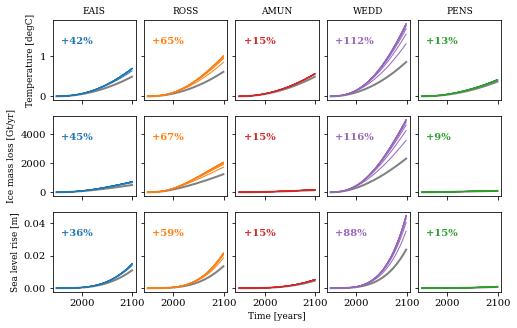

In [5]:
fig,ax = plt.subplots(3,5,sharex=True,sharey='row')

niter = TMP.shape[0]
lws = np.ones(niter)
lws[0] = 2
#lws[-1] = 2

for b,bas in enumerate(ds.basin.values):
    for v,var in enumerate([TMP,IML,SLR]):
        dax = ax[v,b]
        dax.plot(ds.time,var[0,:,b],c='.5',lw=lws[0])
        for n in range(1,niter):
            dax.plot(ds.time,var[n,:,b],c=ut.bcol[bas],lw=lws[n])
        dax.text(.1,.7,f"{100*(var[-1,-1,b]-var[0,-1,b])/var[0,-1,b]:+.0f}%",transform=dax.transAxes,weight='bold',c=ut.bcol[bas])
        
    ax[0,b].set_title(bas)
ax[-1,2].set_xlabel('Time [years]')
ax[0,0].set_ylabel('Temperature [degC]')
ax[1,0].set_ylabel('Ice mass loss [Gt/yr]')
ax[2,0].set_ylabel('Sea level rise [m]')

plt.savefig(f'../draftfigs/single_ensemble.png',dpi=450)
plt.show()

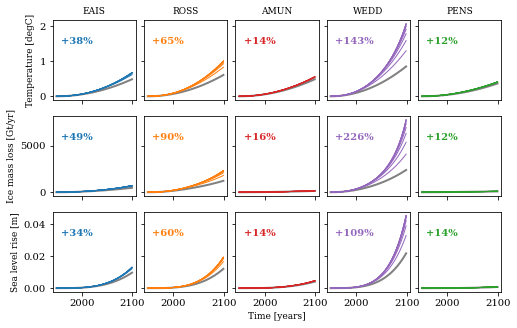

In [6]:
fig,ax = plt.subplots(3,5,sharex=True,sharey='row')

niter = TMP.shape[0]
lws = np.ones(niter)
lws[0] = 2
#lws[-1] = 2

for b,bas in enumerate(ds.basin.values):
    for v,var in enumerate([TMP2,IML2,SLR2]):
        dax = ax[v,b]
        dax.plot(ds.time,var[0,:,b],c='.5',lw=lws[0])
        for n in range(1,niter):
            dax.plot(ds.time,var[n,:,b],c=ut.bcol[bas],lw=lws[n])
        dax.text(.1,.7,f"{100*(var[-1,-1,b]-var[0,-1,b])/var[0,-1,b]:+.0f}%",transform=dax.transAxes,weight='bold',c=ut.bcol[bas])
        
    ax[0,b].set_title(bas)
ax[-1,2].set_xlabel('Time [years]')
ax[0,0].set_ylabel('Temperature [degC]')
ax[1,0].set_ylabel('Ice mass loss [Gt/yr]')
ax[2,0].set_ylabel('Sea level rise [m]')

plt.savefig(f'../draftfigs/single_ensemble_quad.png',dpi=450)
plt.show()

In [15]:
K = 1028*3947/(917*3.34e5)
spy = 3600*24*365.25
print(2e-5*spy*K)
print(99e-5*spy*K**2)

4.1806942360078105
1.9938631411121295
